### Desafío Data Science - Juliana Plácido

### Solución

In [1]:
#Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import optuna
from optuna.integration import OptunaSearchCV
from optuna.exceptions import TrialPruned
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Levantamos la base de datos
df = pd.read_csv('dataset_SCL .csv')

In [3]:
#Vemos la forma de nuestra base:
df.shape

(68206, 18)

In [4]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1.0,1.0,2017.0,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2.0,1.0,2017.0,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3.0,1.0,2017.0,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4.0,1.0,2017.0,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5.0,1.0,2017.0,Jueves,I,American Airlines,Santiago,Miami


#### 1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [5]:
#Queremos ver los valores faltantes por columna
def missing_values():
    temp_dict = dict()
    for i in df.columns:
        if df[i].isnull().sum() > 0: 
            temp_dict[i] = df[i].isnull().sum()
    return temp_dict

missing_values()

{'Vlo-I': 39,
 'Ori-I': 39,
 'Des-I': 39,
 'Emp-I': 39,
 'Fecha-O': 39,
 'Vlo-O': 40,
 'Ori-O': 39,
 'Des-O': 39,
 'Emp-O': 39,
 'DIA': 39,
 'MES': 39,
 'AÑO': 39,
 'DIANOM': 39,
 'TIPOVUELO': 39,
 'OPERA': 39,
 'SIGLAORI': 39,
 'SIGLADES': 39}

Text(0.5, 1.0, 'Cant. de vuelos por dia de la semana')

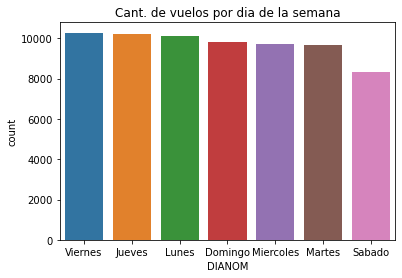

In [6]:
#Cantidad de vuelos por día de semana?
sns.countplot(x = 'DIANOM', data = df, order = df['DIANOM'].value_counts().index) 
plt.title('Cant. de vuelos por dia de la semana')

In [7]:
df.DIANOM.value_counts(normalize = True)

Viernes      0.150791
Jueves       0.150175
Lunes        0.148606
Domingo      0.143706
Miercoles    0.142606
Martes       0.141593
Sabado       0.122523
Name: DIANOM, dtype: float64

Text(0.5, 1.0, 'Vuelos por Aerolínea')

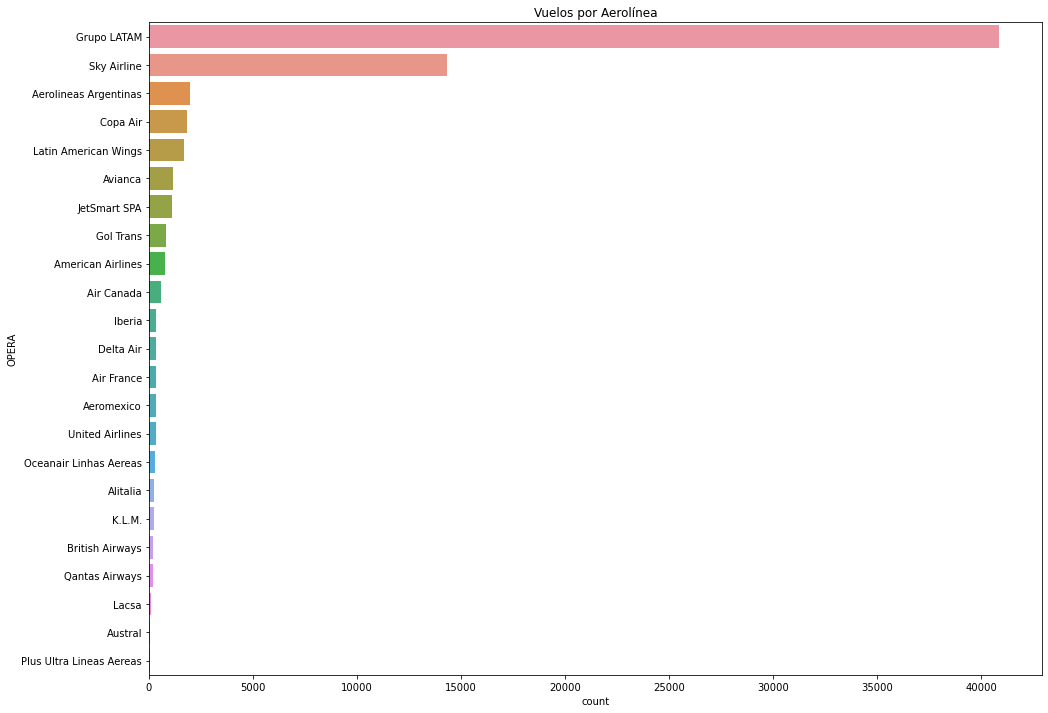

In [8]:
#Qué aerolíneas tenemos en consideración?
plt.figure(figsize=(16, 12))
sns.countplot(y = 'OPERA', data = df, order = df['OPERA'].value_counts().index) 
plt.title('Vuelos por Aerolínea')

In [9]:
#Cant de vuelos por aerolínea
df.OPERA.value_counts()

Grupo LATAM                 40854
Sky Airline                 14298
Aerolineas Argentinas        1949
Copa Air                     1850
Latin American Wings         1674
Avianca                      1152
JetSmart SPA                 1095
Gol Trans                     806
American Airlines             757
Air Canada                    565
Iberia                        362
Delta Air                     358
Air France                    358
Aeromexico                    351
United Airlines               335
Oceanair Linhas Aereas        278
Alitalia                      259
K.L.M.                        251
British Airways               205
Qantas Airways                195
Lacsa                          92
Austral                        74
Plus Ultra Lineas Aereas       49
Name: OPERA, dtype: int64

Text(0.5, 1.0, 'Cant. de vuelos por mes')

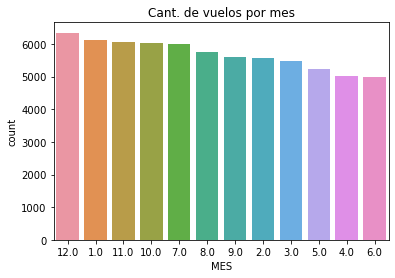

In [10]:
#Vuelos por mes:
sns.countplot(x = 'MES', data = df, order = df['MES'].value_counts().index) 
plt.title('Cant. de vuelos por mes')


In [11]:
#Tipo de vuelo:
display(df.TIPOVUELO.value_counts())
display(df.TIPOVUELO.value_counts(normalize = True)) #Vemos mas vuelos nacionales que internacionales

N    36966
I    31201
Name: TIPOVUELO, dtype: int64

N    0.542286
I    0.457714
Name: TIPOVUELO, dtype: float64

In [12]:
df.TIPOVUELO.unique()

array(['I', 'N', nan], dtype=object)

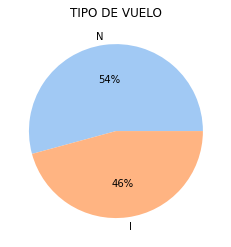

In [13]:
#Para hacer pie chart:
data = df.TIPOVUELO.value_counts()
labels = df.TIPOVUELO.value_counts().index
colors = sns.color_palette('pastel')[0:5]
plt.title('TIPO DE VUELO')
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()


In [14]:
df.describe()

,DIA,MES,AÑO
count,68167.000000,68167.000000,68167.000000
mean,15.714906,6.620359,2017.000029
std,8.782835,3.522783,0.005417
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


In [15]:
df.SIGLAORI.unique() 

array(['Santiago', nan], dtype=object)

In [16]:
df['Ori-O'].value_counts() #Verificamos con la columna correspondiente

SCEL    68167
Name: Ori-O, dtype: int64

In [17]:
df['Ori-I'].value_counts() #Verificamos con la columna correspondiente

SCEL    68167
Name: Ori-I, dtype: int64

##### IMPORTANTE! 
La ciudad de origen siempre es Santiago de Chile, con lo cual, no estamos considerando vuelos cuyo origen es en otro aeropuerto, es decir, vuelos que vienen de otros destinos.

In [18]:
df.SIGLADES.unique() #Listamos las ciudades de destino

array(['Miami', 'Dallas', 'Buenos Aires', 'Toronto', 'Paris',
       'Ciudad de Mexico', 'Bogota', 'Roma', 'Londres',
       'Ciudad de Panama', 'Atlanta', 'Sao Paulo', 'Rio de Janeiro',
       'Florianapolis', 'Madrid', 'Lima', 'Sydney', 'Houston', 'Asuncion',
       'Cataratas Iguacu', 'Puerto Montt', 'Punta Arenas',
       'Puerto Natales', 'Balmaceda', 'Temuco', 'Valdivia', 'Concepcion',
       'La Serena', 'Copiapo', 'Calama', 'Antofagasta', 'Iquique',
       'Arica', 'Mendoza', 'Cordoba', 'Montevideo', 'Castro (Chiloe)',
       'Osorno', 'Orlando', 'Nueva York', 'Guayaquil', 'Cancun',
       'Punta Cana', 'Los Angeles', 'Auckland N.Z.', 'Isla de Pascua',
       'La Paz', 'Santa Cruz', nan, 'Quito', 'Bariloche', 'Rosario',
       'Washington', 'Tucuman', 'Melbourne', 'Neuquen', 'Ushuia',
       'Puerto Stanley', 'Punta del Este', 'Cochabamba'], dtype=object)

In [19]:
df['Des-I'].unique()

array(['KMIA', 'KDFW', 'SAEZ', 'CYYZ', 'LFPG', 'MMMX', 'SABE', 'SKBO',
       'LIRF', 'EGLL', 'MPTO', 'KATL', 'SBGR', 'SBGL', 'SBFL', 'LEMD',
       'SPJC', 'YSSY', 'KIAH', 'SGAS', 'SBFI', 'SCTE', 'SCCI', 'SCNT',
       'SCBA', 'SCVD', 'SCQP', 'SCIE', 'SCSE', 'SCAT', 'SCCF', 'SCFA',
       'SCDA', 'SCAR', 'SAME', 'SACO', 'SUMU', 'SCPQ', 'SCJO', 'KMCO',
       'KJFK', 'SEGU', 'MMUN', 'MDPC', 'KLAX', 'NZAA', 'SCIP', 'SLLP',
       'SLVR', nan, 'SEQM', 'SAZS', 'SAAR', 'SANT', 'YMML', 'SEQU',
       'SAZN', 'SAWH', 'EGYP', 'SULS', 'SLCB', 'SARI'], dtype=object)

In [20]:
df['Des-O'].unique()

array(['KMIA', 'KDFW', 'SAEZ', 'CYYZ', 'LFPG', 'MMMX', 'SABE', 'SKBO',
       'LIRF', 'EGLL', 'MPTO', 'KATL', 'SBGR', 'SBGL', 'SBFL', 'LEMD',
       'SPJC', 'YSSY', 'KIAH', 'SGAS', 'SBFI', 'SCTE', 'SCCI', 'SCNT',
       'SCBA', 'SCQP', 'SCVD', 'SCIE', 'SCSE', 'SCAT', 'SCCF', 'SCFA',
       'SCDA', 'SCAR', 'SAME', 'SACO', 'SUMU', 'SCPQ', 'SCJO', 'KMCO',
       'KJFK', 'SEGU', 'MMUN', 'MDPC', 'KLAX', 'NZAA', 'SCIP', 'SLLP',
       'SLVR', nan, 'SEQM', 'SAZS', 'SAAR', 'KIAD', 'SANT', 'YMML',
       'SAZN', 'SAWH', 'EGYP', 'SULS', 'SLCB'], dtype=object)

In [21]:
display(len(df.SIGLADES.unique()))
display(len(df['Des-I'].unique()))
display(len(df['Des-O'].unique()))

60

62

61

In [22]:
#Ciudades de destino: 
df.SIGLADES.value_counts(normalize = True)

Buenos Aires        0.092934
Antofagasta         0.084880
Lima                0.077310
Calama              0.075491
Puerto Montt        0.063917
Concepcion          0.058577
Iquique             0.054968
Sao Paulo           0.052357
Temuco              0.037980
Arica               0.035736
La Serena           0.035354
Punta Arenas        0.030880
Ciudad de Panama    0.027139
Copiapo             0.026112
Mendoza             0.023839
Bogota              0.023530
Rio de Janeiro      0.021051
Montevideo          0.015638
Cordoba             0.015007
Miami               0.014905
Madrid              0.013115
Balmaceda           0.012308
Valdivia            0.011046
Ciudad de Mexico    0.010269
Isla de Pascua      0.006631
Guayaquil           0.006191
Nueva York          0.005604
Auckland N.Z.       0.005296
Paris               0.005266
Atlanta             0.005252
Dallas              0.005237
Houston             0.004900
Toronto             0.004152
Osorno              0.003799
Roma          

Primeras conclusiones de la rápida evaluación de los datos:
1. Los vuelos son del año 2017
2. Tenemos más vuelos nacionales que internacionales (no vemos una gran diferencia)
3. Aproximadamente un 60% de los vuelos son operados por LATAM
4. El día de la semana con menos vuelos es el sábado
5. El destino más solicitado es Buenos Aires, seguido por Antofagasta (Ciudad portuaria y capital regional en un área minera del Desierto de Atacama, en el norte de Chile)
6. No tenemos un valor significativo de valores faltantes
7. Hay columnas que tienen información repetida (ej SIGLAORI y Ori-O) que al ser columnas categóricas, no nos suman información en un posible modelo. 
8. Los meses con más vuelos son diciembre y enero (meses de vacaciones, temporada alta)
9. Los viernes y jueves son los días con más vuelos (las personas prefieren aprovechar la semana completa comenzando el fin de semana), seguidos por los lunes y domingos(podrían ser los días en los cuales regresan)
10. Todos los vuelos salen del aeropuerto de Chile (según nuestra base de datos)

#### 2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.

- dif_min : diferencia en minutos entre Fecha-O y Fecha-I.

- atraso_15 : 1 si dif_min > 15, 0 si no.

- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I.

In [23]:
#En base a lo evaluado, como los valores nulos no son significativos, los eliminamos de nuestra base
df.dropna(inplace =True)
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        0
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

In [24]:
#Pasamos todas las columnas del df a minuscula:
df = df.rename(columns=str.lower)

In [25]:
for c in df.columns:
    print(c, df[c].dtype)

fecha-i object
vlo-i object
ori-i object
des-i object
emp-i object
fecha-o object
vlo-o object
ori-o object
des-o object
emp-o object
dia float64
mes float64
año float64
dianom object
tipovuelo object
opera object
siglaori object
siglades object


In [26]:
#Queremos ver que vuelos no pertenecen al año 2017, que según vimos en el describe del df, tenemos vuelos en 2018
vista_año = df.año > 2017
df[vista_año]

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
66918,2017-12-31 23:55:00,602.0,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1.0,1.0,2018.0,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622.0,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1.0,1.0,2018.0,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


In [27]:
from datetime import datetime
df['datetime_fechai'] = pd.to_datetime(df['fecha-i'], format="%Y/%m/%d %H:%M:%S")

In [28]:
df['datetime_fechao'] = pd.to_datetime(df['fecha-o'], format="%Y/%m/%d %H:%M:%S")

In [29]:
#verificamos los años
df['year_check'] = pd.DatetimeIndex(df['datetime_fechai']).year

In [30]:
#verificamos los meses
df['month_check'] = pd.DatetimeIndex(df['datetime_fechai']).month

In [31]:
#verificamos los dias
df['day_check'] = pd.DatetimeIndex(df['datetime_fechai']).day

In [32]:
display(df.year_check.describe()) #Si tomamos 'fecha-i' no tenemos info del 2018
display(df.month_check.describe())
display(df.day_check.describe())

count    68166.0
mean      2017.0
std          0.0
min       2017.0
25%       2017.0
50%       2017.0
75%       2017.0
max       2017.0
Name: year_check, dtype: float64

count    68166.000000
mean         6.620661
std          3.522798
min          1.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month_check, dtype: float64

count    68166.000000
mean        15.714388
std          8.783234
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: day_check, dtype: float64

In [33]:
df.head()

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,...,dianom,tipovuelo,opera,siglaori,siglades,datetime_fechai,datetime_fechao,year_check,month_check,day_check
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,2017-01-01 23:30:00,2017-01-01 23:33:00,2017,1,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,2017-01-02 23:30:00,2017-01-02 23:39:00,2017,1,2
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,2017-01-03 23:30:00,2017-01-03 23:39:00,2017,1,3
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,2017-01-04 23:30:00,2017-01-04 23:33:00,2017,1,4
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,2017-01-05 23:30:00,2017-01-05 23:28:00,2017,1,5


##### Armamos flag temporada alta

In [34]:
new_column = []

for index, row in df.iterrows():
    date = row["datetime_fechai"]
    
    # establecemos las condiciones 
    if ((date.month == 12 and date.day >= 15)) or ((date.month == 1)) or ((date.month == 2)) or ((date.month == 3 and date.day <= 3)) or ((date.month == 7 and date.day >= 15) and (date.month == 7 and date.day <= 31)) or ((date.month == 9 and date.day >= 11) and (date.month == 9 and date.day <= 30)):
        new_column.append(1)
    else:
        new_column.append(0)

# Agregamos la columna al df
df["temporada_alta"] = new_column




In [35]:
#Chequeamos el flag temporada_alta
mascara_temporada = df['temporada_alta'] == 0 
df[mascara_temporada].head()

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,...,tipovuelo,opera,siglaori,siglades,datetime_fechai,datetime_fechao,year_check,month_check,day_check,temporada_alta
11670,2017-03-04 23:30:00,226,SCEL,KMIA,AAL,2017-03-04 23:20:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017-03-04 23:30:00,2017-03-04 23:20:00,2017,3,4,0
11671,2017-03-06 23:00:00,226,SCEL,KMIA,AAL,2017-03-06 22:55:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017-03-06 23:00:00,2017-03-06 22:55:00,2017,3,6,0
11672,2017-03-08 23:00:00,226,SCEL,KMIA,AAL,2017-03-08 22:54:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017-03-08 23:00:00,2017-03-08 22:54:00,2017,3,8,0
11673,2017-03-11 22:00:00,226,SCEL,KMIA,AAL,2017-03-11 21:50:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017-03-11 22:00:00,2017-03-11 21:50:00,2017,3,11,0
11674,2017-03-13 22:00:00,226,SCEL,KMIA,AAL,2017-03-13 22:10:00,226,SCEL,KMIA,AAL,...,I,American Airlines,Santiago,Miami,2017-03-13 22:00:00,2017-03-13 22:10:00,2017,3,13,0


##### Diferencia entre la hora programada y la hora de despegue

In [36]:
#Creamos columna para ver la diferencia entre operación y programación del vuelo
df['dif_date'] = (df['datetime_fechao'] - df['datetime_fechai'])

In [37]:
df['dif_date_secs'] = (df['datetime_fechao'] - df['datetime_fechai']).dt.seconds

In [38]:
df['dif_mins'] = df['dif_date_secs'] / 60

In [39]:
#Creamos un flag para ver si el vuelo se adelantó
df['flag_adelantado']=np.where(df.dif_date < '0 days 00:00:00',1, 0) #Este flag no lo podremos usar para modelar porque tiene correlacion alta con el atraso

In [40]:
#Filtramos los vuelos en los cuales el despegue fue antes de lo esperado:
masc = df['dif_date'] < '0 days 00:00:00'
df[masc]

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,...,datetime_fechai,datetime_fechao,year_check,month_check,day_check,temporada_alta,dif_date,dif_date_secs,dif_mins,flag_adelantado
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017-01-05 23:30:00,2017-01-05 23:28:00,2017,1,5,1,-1 days +23:58:00,86280,1438.0,1
6,2017-01-07 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 23:25:00,226,SCEL,KMIA,AAL,...,2017-01-07 23:30:00,2017-01-07 23:25:00,2017,1,7,1,-1 days +23:55:00,86100,1435.0,1
7,2017-01-08 23:30:00,226,SCEL,KMIA,AAL,2017-01-08 23:25:00,226,SCEL,KMIA,AAL,...,2017-01-08 23:30:00,2017-01-08 23:25:00,2017,1,8,1,-1 days +23:55:00,86100,1435.0,1
10,2017-01-14 23:30:00,226,SCEL,KMIA,AAL,2017-01-14 23:21:00,226,SCEL,KMIA,AAL,...,2017-01-14 23:30:00,2017-01-14 23:21:00,2017,1,14,1,-1 days +23:51:00,85860,1431.0,1
12,2017-01-18 23:30:00,226,SCEL,KMIA,AAL,2017-01-18 23:23:00,226,SCEL,KMIA,AAL,...,2017-01-18 23:30:00,2017-01-18 23:23:00,2017,1,18,1,-1 days +23:53:00,85980,1433.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68181,2017-12-03 16:16:00,283.0,SCEL,SCQP,JAT,2017-12-03 16:14:00,283.0,SCEL,SCQP,JAT,...,2017-12-03 16:16:00,2017-12-03 16:14:00,2017,12,3,0,-1 days +23:58:00,86280,1438.0,1
68183,2017-12-17 16:16:00,283.0,SCEL,SCQP,JAT,2017-12-17 16:10:00,283.0,SCEL,SCQP,JAT,...,2017-12-17 16:16:00,2017-12-17 16:10:00,2017,12,17,1,-1 days +23:54:00,86040,1434.0,1
68192,2017-12-29 04:05:00,301.0,SCEL,SCCI,JAT,2017-12-29 04:00:00,301.0,SCEL,SCCI,JAT,...,2017-12-29 04:05:00,2017-12-29 04:00:00,2017,12,29,1,-1 days +23:55:00,86100,1435.0,1
68195,2017-12-23 04:05:00,305.0,SCEL,SCCI,JAT,2017-12-23 04:01:00,305.0,SCEL,SCCI,JAT,...,2017-12-23 04:05:00,2017-12-23 04:01:00,2017,12,23,1,-1 days +23:56:00,86160,1436.0,1


In [41]:
#Filtramos para ver si ese adelantamiento del vuelo es mayor a 10 minutos:
masc = df['dif_date'] < '-1 days +23:50:00'
df[masc]

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,...,datetime_fechai,datetime_fechao,year_check,month_check,day_check,temporada_alta,dif_date,dif_date_secs,dif_mins,flag_adelantado
14,2017-01-23 23:30:00,226,SCEL,KMIA,AAL,2017-01-23 23:19:00,226,SCEL,KMIA,AAL,...,2017-01-23 23:30:00,2017-01-23 23:19:00,2017,1,23,1,-1 days +23:49:00,85740,1429.0,1
17,2017-01-30 23:30:00,226,SCEL,KMIA,AAL,2017-01-30 23:18:00,226,SCEL,KMIA,AAL,...,2017-01-30 23:30:00,2017-01-30 23:18:00,2017,1,30,1,-1 days +23:48:00,85680,1428.0,1
169,2017-01-01 00:15:00,11,SCEL,MMMX,AMX,2017-01-01 00:04:00,11,SCEL,MMMX,AMX,...,2017-01-01 00:15:00,2017-01-01 00:04:00,2017,1,1,1,-1 days +23:49:00,85740,1429.0,1
172,2017-01-04 00:15:00,11,SCEL,MMMX,AMX,2017-01-04 00:03:00,11,SCEL,MMMX,AMX,...,2017-01-04 00:15:00,2017-01-04 00:03:00,2017,1,4,1,-1 days +23:48:00,85680,1428.0,1
190,2017-01-22 22:35:00,11,SCEL,MMMX,AMX,2017-01-22 22:22:00,11,SCEL,MMMX,AMX,...,2017-01-22 22:35:00,2017-01-22 22:22:00,2017,1,22,1,-1 days +23:47:00,85620,1427.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66593,2017-12-25 17:00:00,461.0,SCEL,SABE,LAN,2017-12-25 16:49:00,461.0,SCEL,SABE,LAN,...,2017-12-25 17:00:00,2017-12-25 16:49:00,2017,12,25,1,-1 days +23:49:00,85740,1429.0,1
67366,2017-12-31 14:00:00,1146.0,SCEL,SCFA,LAN,2017-12-31 13:49:00,1146.0,SCEL,SCFA,LAN,...,2017-12-31 14:00:00,2017-12-31 13:49:00,2017,12,31,1,-1 days +23:49:00,85740,1429.0,1
67731,2017-12-08 17:30:00,54.0,SCEL,SCFA,LAW,2017-12-08 17:19:00,54.0,SCEL,SCFA,JMR,...,2017-12-08 17:30:00,2017-12-08 17:19:00,2017,12,8,0,-1 days +23:49:00,85740,1429.0,1
67744,2017-12-27 17:30:00,54.0,SCEL,SCFA,LAW,2017-12-27 17:17:00,54.0,SCEL,SCFA,JMR,...,2017-12-27 17:30:00,2017-12-27 17:17:00,2017,12,27,1,-1 days +23:47:00,85620,1427.0,1


In [42]:
#Siguiendo el criterio que tenemos por default para el target, vamos a ver si tenemos vuelos adelantados con mas de 15 minutos:
masc = df['dif_date'] < '-1 days +23:45:00'
df[masc]

,fecha-i,vlo-i,ori-i,des-i,emp-i,fecha-o,vlo-o,ori-o,des-o,emp-o,...,datetime_fechai,datetime_fechao,year_check,month_check,day_check,temporada_alta,dif_date,dif_date_secs,dif_mins,flag_adelantado


Aclaración:
Luego de comprobar que ningún vuelo se adelantó más de 15 minutos --
Vemos que la diferencia entre fechas, cuando es negativa, no nos sirve para ver los minutos en que el vuelo se adelantó, al igual que los segundos. Así mismo, como lo que queremos es estimar el atraso de los vuelos, los vuelos adelantados los tomaremos como vuelos puntuales, y la diferencia en minutos y segundos la llevaremos a 0.

In [43]:
#Reemplazamos los vuelos adelantados con dif_mins y dif_secs a 0
df.loc[df.flag_adelantado>0, 'dif_mins']=0
df.loc[df.flag_adelantado>0, 'dif_date_secs']=0

##### Creamos flag atraso

In [44]:
#atraso_15 : 1 si dif_min > 15, 0 si no.

df['atraso_15']=np.where(df.dif_mins > 15,1, 0)

##### Creamos columna periodo_dia

In [45]:
def clasificar_periodo_dia(fecha):
    hora = fecha.hour
    if hora >= 5 and hora <= 11:
        return 'mañana'
    elif hora >= 12 and hora <= 18:
        return 'tarde'
    else:
        return 'noche'

# Crear columna "periodo_dia"
df['periodo_dia'] = df['datetime_fechai'].apply(clasificar_periodo_dia)


##### Exportamos las columnas creadas

In [46]:
df.rename(columns = {'dif_mins' : 'dif_min'}, inplace = True)

In [47]:
#Exportamos las columnas creadas junto a la fecha programada de vuelo y el codigo para poder unir, de ser necesario, los datos:
df_export = df[['fecha-i', 'fecha-o', 'vlo-i', 'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]

In [48]:
df_export.to_csv('synthetic_features.csv', index = False)

#### 3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

##### Tipos de variables

In [49]:
df.columns

Index(['fecha-i', 'vlo-i', 'ori-i', 'des-i', 'emp-i', 'fecha-o', 'vlo-o',
       'ori-o', 'des-o', 'emp-o', 'dia', 'mes', 'año', 'dianom', 'tipovuelo',
       'opera', 'siglaori', 'siglades', 'datetime_fechai', 'datetime_fechao',
       'year_check', 'month_check', 'day_check', 'temporada_alta', 'dif_date',
       'dif_date_secs', 'dif_min', 'flag_adelantado', 'atraso_15',
       'periodo_dia'],
      dtype='object')

In [50]:
df['siglaori'].unique()

array(['Santiago'], dtype=object)

In [51]:
#Vamos a dropear las variables que no necesitaremos en nuestro análisis:
#Dropeamos el año ya que es todo 2017, 
#Dropeamos 'opera' ya que tenemos la info en las columnas emp-i
#Dropeamos 'emp-o' ya que queremos saber el atraso para lo que usaremos la aerolinea programada
#Dropeamos 'ori-o', 'ori-i', -- info unica junto a siglaori
#Dropeamos 'des-o', 'vlo-o', (nos interesa el programado)
#Dropeamos 'fecha-o' porque ya tenemos la info que necesitamos del atraso
#Dropeamos 
df.drop(columns = ['año', 'emp-o', 'ori-o', 'des-o', 'vlo-o', 'ori-i', 'siglaori', 'fecha-o', 'datetime_fechao', 'year_check', 'month_check', 'day_check','dif_date', 'dif_date_secs', 'dif_min'], inplace = True)

In [52]:
def lista_variables(df):
    
    var_list = df.columns.tolist()
    
    df_result = pd.DataFrame(columns=['Variable', 'Tipo', 'Format'])
    
    for i in range(len(var_list)):
        if df[var_list[i]].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            var_type = 'Num'
        else:
            var_type = 'Alfanum'
        
        new_row = pd.Series([var_list[i], var_type, df[var_list[i]].dtype],
                           index=['Variable', 'Tipo', 'Format'])
        
        df_result = df_result.append(new_row, ignore_index=True)
    
    df_result.index += 1
    
    return df_result

In [53]:
df_dtype = lista_variables(df)

In [54]:
#Categóricas
categorical_var_list = df_dtype.Variable[df_dtype.Tipo == 'Alfanum'].tolist()
categorical_var_list = [i for i in categorical_var_list]
len(categorical_var_list)

10

In [55]:
categorical_var_list

['fecha-i',
 'vlo-i',
 'des-i',
 'emp-i',
 'dianom',
 'tipovuelo',
 'opera',
 'siglades',
 'datetime_fechai',
 'periodo_dia']

##### Evaluamos la tasa de atraso por diferentes variables

día de semana

In [56]:
#Chequeamos las métricas de target por dia de semana
vista_grouped = df.groupby(
                        df.dianom).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
              count   sum      mean
dianom                             
Viernes       10279  2281  0.221909
Lunes         10130  2048  0.202172
Jueves        10236  2043  0.199590
Miercoles      9721  1661  0.170867
Martes         9652  1632  0.169084
Sabado         8352  1363  0.163194
Domingo        9796  1578  0.161086

destino

In [57]:
#Chequeamos las métricas de target por destino
vista_grouped = df.groupby(
                        df.siglades).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
                     count   sum      mean
siglades                                  
Puerto Stanley           1     1  1.000000
Cochabamba               1     1  1.000000
Quito                    2     2  1.000000
Ushuia                   6     4  0.666667
Sydney                 194   113  0.582474
Melbourne               39    21  0.538462
Bariloche                2     1  0.500000
Rosario                136    54  0.397059
Auckland N.Z.          361   135  0.373961
Punta Cana              54    18  0.333333
Toronto                283    89  0.314488
Cordoba               1023   308  0.301075
Asuncion               232    66  0.284483
Rio de Janeiro        1435   405  0.282230
Mendoza               1625   443  0.272615
Orlando                 34     9  0.264706
Tucuman                 38    10  0.263158
Bogota                1604   415  0.258728
Buenos Aires          6335  1620  0.255722
Los Angeles            155    39  0.251613
Santa Cruz             120    30  0.250000
Sao Paulo             3569   881  0.246848
Lima                  5269  1214  0.230404
Nueva York             382    82  0.214660
Montevideo            1066   220  0.206379
Isla de Pascua         452    89  0.196903
Guayaquil              422    82  0.194313
Osorno                 259    50  0.193050
Miami                 1016   194  0.190945
Cancun                  63    12  0.190476
Madrid                 894   170  0.190157
Florianapolis          162    30  0.185185
Iquique               3747   640  0.170803
Puerto Montt          4357   734  0.168465
Punta del Este           6     1  0.166667
La Serena             2410   390  0.161826
Concepcion            3993   623  0.156023
Temuco                2589   403  0.155659
Valdivia               753   117  0.155378
Punta Arenas          2105   324  0.153919
La Paz                 209    32  0.153110
Balmaceda              839   123  0.146603
Antofagasta           5786   847  0.146388
Londres                205    29  0.141463
Copiapo               1780   242  0.135955
Arica                 2436   330  0.135468
Calama                5146   629  0.122231
Roma                   259    29  0.111969
Neuquen                 37     4  0.108108
Ciudad de Mexico       700    66  0.094286
Puerto Natales          79     7  0.088608
Paris                  359    31  0.086351
Castro (Chiloe)        235    18  0.076596
Dallas                 357    25  0.070028
Ciudad de Panama      1850   116  0.062703
Atlanta                358    21  0.058659
Houston                334    17  0.050898
Cataratas Iguacu         2     0  0.000000
Washington               1     0  0.000000

aerolinea

In [58]:
#Chequeamos las métricas de target por aerolinea de operacion de vuelo
vista_grouped = df.groupby(
                        df.opera).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
                             count   sum      mean
opera                                             
Plus Ultra Lineas Aereas        49    30  0.612245
Qantas Airways                 195   113  0.579487
Air Canada                     565   258  0.456637
Latin American Wings          1673   681  0.407053
Gol Trans                      806   287  0.356079
Avianca                       1152   306  0.265625
Aerolineas Argentinas         1949   468  0.240123
Austral                         74    15  0.202703
JetSmart SPA                  1095   196  0.178995
Grupo LATAM                  40854  7298  0.178636
Sky Airline                  14298  2540  0.177647
Oceanair Linhas Aereas         278    43  0.154676
British Airways                205    29  0.141463
Lacsa                           92    11  0.119565
Alitalia                       259    29  0.111969
Iberia                         362    36  0.099448
Air France                     358    30  0.083799
K.L.M.                         251    21  0.083665
American Airlines              757    51  0.067371
Copa Air                      1850   116  0.062703
Delta Air                      358    21  0.058659
United Airlines                335    17  0.050746
Aeromexico                     351    10  0.028490

mes del año

In [59]:
#Chequeamos las métricas de target por mes de operación
vista_grouped = df.groupby(
                        df.mes).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
         count   sum      mean
mes                           
7.0       5992  1758  0.293391
12.0      6344  1611  0.253941
10.0      6020  1360  0.225914
11.0      6068  1198  0.197429
8.0       5743   996  0.173429
9.0       5610   967  0.172371
6.0       4981   852  0.171050
1.0       6107   978  0.160144
5.0       5240   827  0.157824
2.0       5561   843  0.151591
4.0       5020   585  0.116534
3.0       5480   631  0.115146

temporada

In [60]:
#Chequeamos las métricas de target por temporada (alta vs baja)
vista_grouped = df.groupby(
                        df.temporada_alta).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
                   count   sum      mean
temporada_alta                          
1                  22755  4468  0.196352
0                  45411  8138  0.179208

tipo de vuelo

In [61]:
#Chequeamos las métricas de target por vuelo (n vs i)
vista_grouped = df.groupby(
                        df.tipovuelo).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
              count   sum      mean
tipovuelo                          
I             31200  7040  0.225641
N             36966  5566  0.150571

In [62]:
# obs: vemos mas diferencia en las métricas del target por tipo de vuelo que por temporada

periodo dia

In [63]:
#Chequeamos las métricas de target por vuelo (n vs i)
vista_grouped = df.groupby(
                        df.periodo_dia).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
                count   sum      mean
periodo_dia                          
noche           17347  3470  0.200035
tarde           25504  5086  0.199420
mañana          25315  4050  0.159984

Estacion del año

In [64]:
#Creamos la variable para ver de que estacion se trata (ya la creamos encodeada):
'''
Verano: desde el 21 de diciembre (solsticio) al 20 de marzo (equinoccio). 1
Otoño: desde el 20 de marzo (equinoccio) al 21 de junio (solsticio). 2
Invierno: desde el 21 de junio (solsticio) al 21 de septiembre (equinoccio). 3
Primavera: desde el 21 de septiembre (equinoccio) al 21 de diciembre (solsticio). 4
'''
def obtener_estacion(fecha):
    # Verano
    if (fecha.month == 12 and fecha.day >= 21) or (fecha.month == 1 or fecha.month == 2) or (fecha.month == 3 and fecha.day <= 20):
        return 1
    # Otoño
    elif (fecha.month == 3 and fecha.day >= 21) or (fecha.month == 4 or fecha.month == 5) or (fecha.month == 6 and fecha.day <= 20):
        return 2
    # Invierno
    elif (fecha.month == 6 and fecha.day >= 21) or (fecha.month == 7 or fecha.month == 8) or (fecha.month == 9 and fecha.day <= 20):
        return 3
    # Primavera
    else:
        return 4

# Aplicamos la función a la columna 'fecha' y guardamos el resultado en una nueva columna 'estacion'
df['estacion'] = df['datetime_fechai'].apply(obtener_estacion)

In [65]:
mascara_check = df['estacion'] == 4 
df[mascara_check]

,fecha-i,vlo-i,des-i,emp-i,dia,mes,dianom,tipovuelo,opera,siglades,datetime_fechai,temporada_alta,flag_adelantado,atraso_15,periodo_dia,estacion
44137,2017-09-21 21:00:00,912,KMIA,AAL,21.0,9.0,Jueves,I,American Airlines,Miami,2017-09-21 21:00:00,1,1,0,noche,4
44138,2017-09-22 21:00:00,912,KMIA,AAL,22.0,9.0,Viernes,I,American Airlines,Miami,2017-09-22 21:00:00,1,0,1,noche,4
44139,2017-09-23 21:00:00,912,KMIA,AAL,23.0,9.0,Sabado,I,American Airlines,Miami,2017-09-23 21:00:00,1,1,0,noche,4
44140,2017-09-24 21:00:00,912,KMIA,AAL,24.0,9.0,Domingo,I,American Airlines,Miami,2017-09-24 21:00:00,1,1,0,noche,4
44141,2017-09-25 21:00:00,912,KMIA,AAL,25.0,9.0,Lunes,I,American Airlines,Miami,2017-09-25 21:00:00,1,1,0,noche,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68181,2017-12-03 16:16:00,283.0,SCQP,JAT,3.0,12.0,Domingo,N,JetSmart SPA,Temuco,2017-12-03 16:16:00,0,1,0,tarde,4
68182,2017-12-10 16:16:00,283.0,SCQP,JAT,10.0,12.0,Domingo,N,JetSmart SPA,Temuco,2017-12-10 16:16:00,0,0,0,tarde,4
68183,2017-12-17 16:16:00,283.0,SCQP,JAT,17.0,12.0,Domingo,N,JetSmart SPA,Temuco,2017-12-17 16:16:00,1,1,0,tarde,4
68194,2017-12-18 20:11:00,305.0,SCCI,JAT,18.0,12.0,Lunes,N,JetSmart SPA,Punta Arenas,2017-12-18 20:11:00,1,0,0,noche,4


In [66]:
#Chequeamos las métricas de target por estacion
vista_grouped = df.groupby(
                        df.estacion).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[-1], ascending=False)

vista_grouped_sorted

atraso_15                
             count   sum      mean
estacion                          
3            17120  3715  0.216998
4            18095  3895  0.215253
1            17464  2777  0.159013
2            15487  2219  0.143281

In [67]:
#Chequeamos las métricas de target por cod de vuelo
vista_grouped = df.groupby(
                        df['vlo-i']).agg({'atraso_15':["count","sum","mean"]})
vista_grouped_sorted = vista_grouped.sort_values(by=vista_grouped.columns[0], ascending=False)

vista_grouped_sorted

atraso_15               
          count  sum      mean
vlo-i                         
174         686   90  0.131195
11          645   30  0.046512
116         608  233  0.383224
150         557   80  0.143627
162         553   55  0.099458
...         ...  ...       ...
1035          1    1  1.000000
1034          1    0  0.000000
1004          1    1  1.000000
4950          1    1  1.000000
9956          1    0  0.000000

[746 rows x 3 columns]

In [66]:
vista = df['vlo-i'] == '174'
df[vista]

,fecha-i,vlo-i,des-i,emp-i,dia,mes,dianom,tipovuelo,opera,siglades,datetime_fechai,temporada_alta,flag_adelantado,atraso_15,periodo_dia,estacion
539,2017-01-01 03:20:00,174,MPTO,CMP,1.0,1.0,Domingo,I,Copa Air,Ciudad de Panama,2017-01-01 03:20:00,1,1,0,noche,1
540,2017-01-02 03:20:00,174,MPTO,CMP,2.0,1.0,Lunes,I,Copa Air,Ciudad de Panama,2017-01-02 03:20:00,1,1,0,noche,1
541,2017-01-04 03:20:00,174,MPTO,CMP,4.0,1.0,Miercoles,I,Copa Air,Ciudad de Panama,2017-01-04 03:20:00,1,1,0,noche,1
542,2017-01-05 03:20:00,174,MPTO,CMP,5.0,1.0,Jueves,I,Copa Air,Ciudad de Panama,2017-01-05 03:20:00,1,1,0,noche,1
543,2017-01-06 03:20:00,174,MPTO,CMP,6.0,1.0,Viernes,I,Copa Air,Ciudad de Panama,2017-01-06 03:20:00,1,1,0,noche,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65102,2017-12-21 21:25:00,174,SCDA,LAN,21.0,12.0,Jueves,N,Grupo LATAM,Iquique,2017-12-21 21:25:00,1,1,0,noche,1
65103,2017-12-22 22:14:00,174,SCDA,LAN,22.0,12.0,Viernes,N,Grupo LATAM,Iquique,2017-12-22 22:14:00,1,0,0,noche,1
65104,2017-12-27 20:03:00,174,SCDA,LAN,27.0,12.0,Miercoles,N,Grupo LATAM,Iquique,2017-12-27 20:03:00,1,0,1,noche,1
65105,2017-12-28 21:20:00,174,SCDA,LAN,28.0,12.0,Jueves,N,Grupo LATAM,Iquique,2017-12-28 21:20:00,1,1,0,noche,1


En resumen:
1. Los fines de semana (Sábado y Domingo) hay menos atraso que los días de semana. Por el contrario, los días con mayor promedio de atraso son los viernes y los lunes, seguidos de los jueves.

Importante: los viernes y los jueves son los días con más vuelos, lo que nos hace sentido que sean los días con más atraso (congestión en las pistas de despegue, más personas en el aeropuerto, etc). Las personas eligen viajar antes que comience el fin de semana para poder aprovecharlo, ya sea pocos días o la semana completa.

Siguiendo esta línea de pensamiento, el periodo del día con más atraso es la noche, que es cuando menos vuelos hay. Lo que podríamos pensar es que si los lunes son días muy concurridos y con bastante atraso, nos hace sentido que las personas vuelvan de los viajes domingo por la noche (en realidad madrugada del lunes) siendo vuelos muy solicitados.

Desde una vista de negocio, conviene operar vuelos estos días, ya que son los vuelos más solicitados, pero así mismo son vuelos que pueden atrasarse debido a condiciones externas a la aerolínea. 

2. Julio y Diciembre son los meses con mayor promedio de atraso (coincide con épocas de vacaciones de verano/invierno) pero sin embargo no vemos una gran diferencia en el promedio de atraso para vuelos de temporada alta vs temporada baja. 

3. Vemos que a la noche, el promedio de atraso es claramente mayor que en los otros rangos horarios. El menor atraso es en vuelos matutinos. Sin embargo, hay muchos más vuelos por la mañana que por la noche. A pesar de esto, los vuelos más solicitados son por la tarde.

Siguiendo lo analizado anteriormente, por la noche tenemos presentes otras condiciones que pueden afectar los vuelos (externas a la aerolínea), menos personal, menos pistas habilitadas, etc.

4. La aerolínea "Plus Ultra Lineas Aereas" tiene un 61,2 % de atraso seguida por "Qantas Airways" con un 58% de atraso, que si bien son aerolíneas que no tienen muchos vuelos, los que tienen, tienden a atrasarse. Probablemente tienen poco personal operando, pocos aviones, etc.

##### Los últimos dos puntos del challenge los responderemos de manera conjunta

#### 4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.

#### 5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

##### Encodeamos variables categóricas:

In [67]:
categorical_var_list

['fecha-i',
 'vlo-i',
 'des-i',
 'emp-i',
 'dianom',
 'tipovuelo',
 'opera',
 'siglades',
 'datetime_fechai',
 'periodo_dia']

In [68]:
df

,fecha-i,vlo-i,des-i,emp-i,dia,mes,dianom,tipovuelo,opera,siglades,datetime_fechai,temporada_alta,flag_adelantado,atraso_15,periodo_dia,estacion
0,2017-01-01 23:30:00,226,KMIA,AAL,1.0,1.0,Domingo,I,American Airlines,Miami,2017-01-01 23:30:00,1,0,0,noche,1
1,2017-01-02 23:30:00,226,KMIA,AAL,2.0,1.0,Lunes,I,American Airlines,Miami,2017-01-02 23:30:00,1,0,0,noche,1
2,2017-01-03 23:30:00,226,KMIA,AAL,3.0,1.0,Martes,I,American Airlines,Miami,2017-01-03 23:30:00,1,0,0,noche,1
3,2017-01-04 23:30:00,226,KMIA,AAL,4.0,1.0,Miercoles,I,American Airlines,Miami,2017-01-04 23:30:00,1,0,0,noche,1
4,2017-01-05 23:30:00,226,KMIA,AAL,5.0,1.0,Jueves,I,American Airlines,Miami,2017-01-05 23:30:00,1,1,0,noche,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400.0,SPJC,JAT,22.0,12.0,Viernes,I,JetSmart SPA,Lima,2017-12-22 14:55:00,1,0,1,tarde,1
68202,2017-12-25 14:55:00,400.0,SPJC,JAT,25.0,12.0,Lunes,I,JetSmart SPA,Lima,2017-12-25 14:55:00,1,0,1,tarde,1
68203,2017-12-27 14:55:00,400.0,SPJC,JAT,27.0,12.0,Miercoles,I,JetSmart SPA,Lima,2017-12-27 14:55:00,1,0,1,tarde,1
68204,2017-12-29 14:55:00,400.0,SPJC,JAT,29.0,12.0,Viernes,I,JetSmart SPA,Lima,2017-12-29 14:55:00,1,0,0,tarde,1


##### Vamos a encodear:

-des-i = codigo ciudad de destino (== siglades). Nos importa la ciudad a la que originalmente el vuelo atrasado se dirigía, ya que queremos evaluar ese atraso.

-emp-i = codigo de aerolínea (== opera)

-dianom = dia de la semana

-tipovuelo = internacional o nacional

-periodo_día = mañana, tarde, noche (vemos que hay dif en el target)

#### IMPORTANTE!

Todos los vuelos del dataset tienen origen en Santiago de Chile, ya sea origen programado y origen operado.

In [70]:
#Encodeamos tipo de vuelo:
df['tipo_vuelo'] = df['tipovuelo'].map({'I': 0,
                                        'N': 1},
                                         na_action=None)

In [71]:
#Dropeamos la variable cat:
df.drop(columns = ['tipovuelo'], inplace = True)

In [72]:
#Encodeamos periodo_dia
df['periodo_dia_cat'] = df['periodo_dia'].map({'noche': 0,
                                                'tarde': 1,
                                                'mañana': 2},
                                                 na_action=None)

In [73]:
#dropeamos la variable cat:
df.drop(columns = ['periodo_dia'], inplace = True)
#renombramos la variable encodeada:
df.rename(columns = {'periodo_dia_cat' : 'periodo_dia'}, inplace = True)

In [74]:
#Encodeamos el dia de la semana:
#Para esto vamos a usar one hot encoding ya que tendremos una columna por cada dia de la semana
dias_semana = pd.get_dummies(df['dianom'])
df = pd.concat([df, dias_semana], axis=1)


In [75]:
#dropeamos la variable original:
df.drop(columns = ['dianom'], inplace = True)

In [76]:
#Encodeamos la ciudad de destino:
#la codificación de etiquetas se basa en la asignación arbitraria de valores numéricos a las categorías. Por lo tanto, esta técnica es más adecuada para variables categóricas sin orden intrínseco.
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['cod_destino'] = le.fit_transform(df['des-i'])


In [77]:
#Encodeamos la aerolínea:
le = LabelEncoder()
df['cod_aerolinea'] = le.fit_transform(df['emp-i'])

In [78]:
#Verificamos las variables creadas:

In [79]:
df['des-i'].unique()

array(['KMIA', 'KDFW', 'SAEZ', 'CYYZ', 'LFPG', 'MMMX', 'SABE', 'SKBO',
       'LIRF', 'EGLL', 'MPTO', 'KATL', 'SBGR', 'SBGL', 'SBFL', 'LEMD',
       'SPJC', 'YSSY', 'KIAH', 'SGAS', 'SBFI', 'SCTE', 'SCCI', 'SCNT',
       'SCBA', 'SCVD', 'SCQP', 'SCIE', 'SCSE', 'SCAT', 'SCCF', 'SCFA',
       'SCDA', 'SCAR', 'SAME', 'SACO', 'SUMU', 'SCPQ', 'SCJO', 'KMCO',
       'KJFK', 'SEGU', 'MMUN', 'MDPC', 'KLAX', 'NZAA', 'SCIP', 'SLLP',
       'SLVR', 'SEQM', 'SAZS', 'SAAR', 'SANT', 'YMML', 'SEQU', 'SAZN',
       'SAWH', 'EGYP', 'SULS', 'SLCB', 'SARI'], dtype=object)

In [80]:
df['cod_destino'].unique()

array([ 9,  4, 21,  0, 11, 14, 19, 52, 12,  1, 16,  3, 31, 30, 29, 10, 56,
       60,  5, 51, 28, 46, 36, 42, 34, 47, 44, 39, 45, 33, 35, 38, 37, 32,
       22, 20, 58, 43, 41,  8,  6, 48, 15, 13,  7, 17, 40, 54, 55, 49, 27,
       18, 23, 59, 50, 26, 25,  2, 57, 53, 24])

In [81]:
len(df['cod_destino'].unique())

61

In [82]:
len(df['des-i'].unique())

61

In [83]:
#Eliminamos las variables que ya no vamos a necesitar:
df_modelado = df.drop(columns = ['opera', 'siglades','des-i', 'emp-i','datetime_fechai'])

In [84]:
df_modelado

,fecha-i,vlo-i,dia,mes,temporada_alta,flag_adelantado,atraso_15,estacion,tipo_vuelo,periodo_dia,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,cod_destino,cod_aerolinea
0,2017-01-01 23:30:00,226,1.0,1.0,1,0,0,1,0,0,1,0,0,0,0,0,0,9,0
1,2017-01-02 23:30:00,226,2.0,1.0,1,0,0,1,0,0,0,0,1,0,0,0,0,9,0
2,2017-01-03 23:30:00,226,3.0,1.0,1,0,0,1,0,0,0,0,0,1,0,0,0,9,0
3,2017-01-04 23:30:00,226,4.0,1.0,1,0,0,1,0,0,0,0,0,0,1,0,0,9,0
4,2017-01-05 23:30:00,226,5.0,1.0,1,1,0,1,0,0,0,1,0,0,0,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400.0,22.0,12.0,1,0,1,1,0,1,0,0,0,0,0,0,1,56,14
68202,2017-12-25 14:55:00,400.0,25.0,12.0,1,0,1,1,0,1,0,0,1,0,0,0,0,56,14
68203,2017-12-27 14:55:00,400.0,27.0,12.0,1,0,1,1,0,1,0,0,0,0,1,0,0,56,14
68204,2017-12-29 14:55:00,400.0,29.0,12.0,1,0,0,1,0,1,0,0,0,0,0,0,1,56,14


### Estudiamos correlaciones:
##### Ahora que tenemos nuestro dataset preparado, podemos ver la correlacion con el target elegido

In [85]:
df_modelado.corr()

,dia,mes,temporada_alta,flag_adelantado,atraso_15,estacion,tipo_vuelo,periodo_dia,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,cod_destino,cod_aerolinea
dia,1.000000,0.014284,0.192817,0.012833,-0.002627,-0.001992,0.001269,0.001926,-0.005113,0.008602,0.003012,0.019179,-0.015506,-0.006329,-0.004304,0.000500,0.002552
mes,0.014284,1.000000,-0.294131,-0.062876,0.083384,0.828383,0.012235,0.006437,-0.005103,0.006483,-0.011662,-0.003960,0.000425,0.004014,0.009886,-0.007461,0.002149
temporada_alta,0.192817,-0.294131,1.000000,-0.016659,0.020825,-0.411219,0.000818,-0.020033,-0.000805,-0.012884,0.003448,-0.012671,-0.005608,0.020204,0.009536,0.008846,0.012384
flag_adelantado,0.012833,-0.062876,-0.016659,1.000000,-0.284291,-0.056179,-0.008580,-0.016480,0.023002,-0.013579,-0.008591,0.015669,0.005029,0.022094,-0.040877,-0.078159,-0.049094
atraso_15,-0.002627,0.083384,0.020825,-0.284291,1.000000,0.069759,-0.096333,-0.043151,-0.025161,0.015871,0.018553,-0.016577,-0.014773,-0.020921,0.040135,0.006034,0.011903
estacion,-0.001992,0.828383,-0.411219,-0.056179,0.069759,1.000000,0.010358,0.007931,-0.012446,0.001021,0.000145,0.009155,0.011774,-0.008855,-0.001275,-0.008530,-0.001188
tipo_vuelo,0.001269,0.012235,0.000818,-0.008580,-0.096333,0.010358,1.000000,0.160170,-0.005314,0.021438,0.012050,0.008005,0.002641,-0.060010,0.016438,0.338926,0.292657
periodo_dia,0.001926,0.006437,-0.020033,-0.016480,-0.043151,0.007931,0.160170,1.000000,-0.018176,-0.009841,0.015175,0.006280,-0.003609,0.025773,-0.013650,0.165995,0.124004
Domingo,-0.005113,-0.005103,-0.000805,0.023002,-0.025161,-0.012446,-0.005314,-0.018176,1.000000,-0.172204,-0.171153,-0.166383,-0.167075,-0.153082,-0.172629,-0.006551,0.001868
Jueves,0.008602,0.006483,-0.012884,-0.013579,0.015871,0.001021,0.021438,-0.009841,-0.172204,1.000000,-0.175618,-0.170723,-0.171433,-0.157075,-0.177133,0.003369,-0.001009


Tal como fuimos viendo en los análisis anteriores, el tipo de vuelo y el mes del año podrían ser buenas variables predictoras. Lo mismo ocurre con el período del día.

In [86]:
#Exportamos el df para modelar:
df_modelado.to_csv('df_modelado.csv', index = False)

#### Baseline Model

In [2]:
#Reiniciamos el kernel e importamos nuevamente los datos
df = pd.read_csv('df_modelado.csv')

In [3]:
X = df.drop(['vlo-i','fecha-i', 'atraso_15', 'flag_adelantado'], axis=1)
y = df['atraso_15']

In [4]:
from sklearn.model_selection import train_test_split
trainSize = 0.7

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                  train_size=trainSize)

In [5]:
print('Shape X:', X_train.shape)
print('Shape y:', y_train.shape)

Shape X: (47716, 15)
Shape y: (47716,)


In [6]:
print('Shape X:', X_test.shape)
print('Shape y:', y_test.shape)

Shape X: (20450, 15)
Shape y: (20450,)


Lo primero que vamos a hacer es una Regresión Logística como modelo benchmark para tener una referencia inicial. 
Así mismo, iremos probando diversos modelos hasta llegar a los que más nos interesan: lgbm y XGBoost. 
Como métricas, utilizaremos:

-Curva ROC: Es una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario. Es decir, es la representación de la proporción de Verdaderos Positivos (VPR) frente a la proporción de Falsos Positivos (FPR) también según se varía el umbral de discriminación. En resumen, la curva roc nos da una idea de que tan bueno es el modelo distinguiendo las clases. 
Esta métrica la utilizaremos para comparar nuestros modelos, sin embargo, al momento de evaluar nuestro modelo final utilizaremos diversos métodos como la precisión (podemos medir la calidad del modelo), exhaustividad/recall (nos va a informar sobre la cantidad que el modelo es capaz de identificar) y F1 combinando ambas métricas en un solo valor. 

#### Regresión Logística

In [8]:
#Logistic Regression:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

#Predict
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Logistic Reg Baseline Train: " + str(train_roc))
print("Logistic Reg Baseline Test: " + str(test_roc))

Logistic Reg Baseline Train: 0.6205
Logistic Reg Baseline Test: 0.6184


#### Decision Tree Classifier

In [9]:
#Decision Tree Classifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
#Predict
y_train_pred = tree.predict_proba(X_train)[:,1]
y_test_pred = tree.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Tree Classifier Baseline Train: " + str(train_roc))
print("Tree Classifier Baseline Test: " + str(test_roc))

Tree Classifier Baseline Train: 0.9891
Tree Classifier Baseline Test: 0.5942


Estos algoritmos los hacemos de prueba, ya sabemos que al momento de encodear elegimos métodos que con el árbol pueden generar overfitting (y al ver la diferencia entre rocs es algo que claramente está ocurriendo en el árbol de decisión)

#### Random Forest

In [10]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
trees = RandomForestClassifier(random_state=42)
trees.fit(X_train, y_train)
#Predict
y_train_pred = trees.predict_proba(X_train)[:,1]
y_test_pred = trees.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, y_train_pred) ,4) 
test_roc = round(roc_auc_score(y_test, y_test_pred) ,4)

print("Random Forest Classifier Baseline Train: " + str(train_roc))
print("Random Forest Classifier Test: " + str(test_roc))

Random Forest Classifier Baseline Train: 0.9881
Random Forest Classifier Test: 0.6746


#### Probamos algoritmos más complejos

### LGBM

In [10]:
%%time
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

preds_lgbm_train = model_lgbm.predict_proba(X_train)[:,1]
preds_lgbm_test = model_lgbm.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_lgbm_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_lgbm_test) ,4)


print("ROC LGBM Baseline Train: " + str(train_roc))
print("ROC LGBM Baseline Test: " + str(test_roc))

ROC LGBM Baseline Train: 0.7737
ROC LGBM Baseline Test: 0.7286
CPU times: user 3.4 s, sys: 21.9 ms, total: 3.42 s
Wall time: 4.02 s


In [11]:
feature_imp = pd.DataFrame()
feature_imp['Variable'] = X.columns
feature_imp['importance'] = model_lgbm.feature_importances_
feature_imp['import_percent'] = feature_imp.importance / feature_imp.importance.sum()
feature_imp = feature_imp.sort_values(by='import_percent', ascending=False)
feature_imp.head(12)

,Variable,importance,import_percent
0,dia,744,0.248000
1,mes,573,0.191000
13,cod_destino,505,0.168333
14,cod_aerolinea,438,0.146000
5,periodo_dia,240,0.080000
3,estacion,67,0.022333
2,temporada_alta,63,0.021000
6,Domingo,56,0.018667
8,Lunes,54,0.018000
4,tipo_vuelo,53,0.017667


<Figure size 1080x864 with 0 Axes>

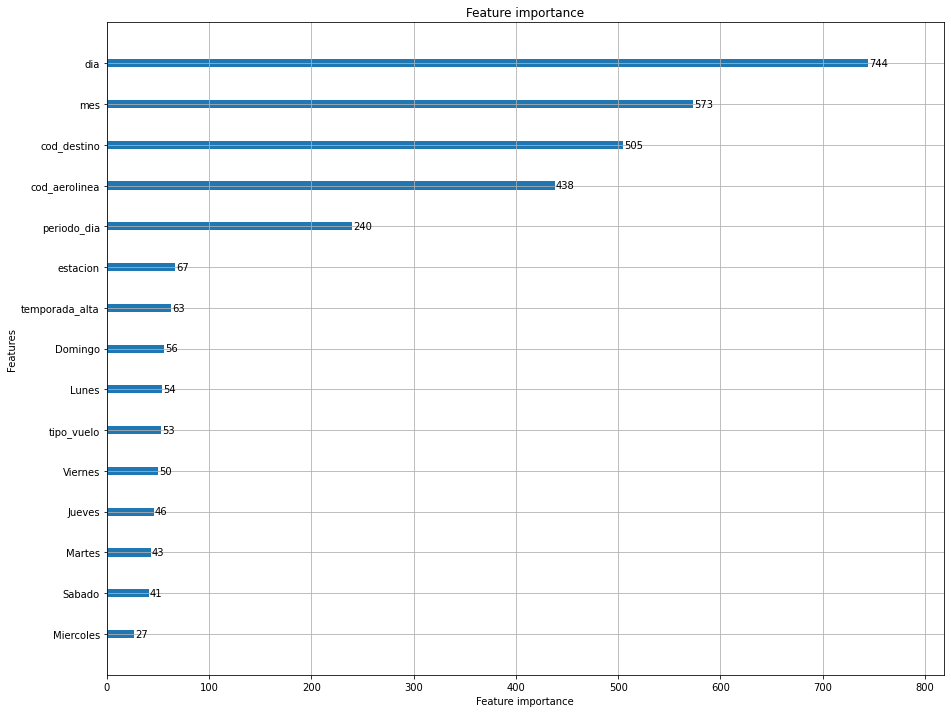

In [12]:
plt.figure(figsize=(15,12))
lgb.plot_importance(model_lgbm,
                    max_num_features=40,
                    importance_type='split',
                    figsize=(15,12))
plt.show()

### XGBoost

In [11]:
%%time
model_xgboost = XGBClassifier(random_state=42)
model_xgboost.fit(X_train, y_train)

preds_xgb_train = model_xgboost.predict_proba(X_train)[:,1]
preds_xgb_test = model_xgboost.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_xgb_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_xgb_test) ,4)

print("ROC XGBoost Baseline Train: " + str(train_roc))
print("ROC XGBoost Baseline Test: " + str(test_roc))

ROC XGBoost Baseline Train: 0.8273
ROC XGBoost Baseline Test: 0.7321
CPU times: user 11.3 s, sys: 949 ms, total: 12.2 s
Wall time: 1.61 s


In [12]:
feat_imp_xgb = pd.DataFrame()
feat_imp_xgb['Variable'] = X_train.columns
feat_imp_xgb['importance'] = model_xgboost.feature_importances_
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)
feat_imp_xgb.head(12)

,Variable,importance
4,tipo_vuelo,0.256244
5,periodo_dia,0.073749
14,cod_aerolinea,0.070424
1,mes,0.068983
8,Lunes,0.063576
13,cod_destino,0.060215
12,Viernes,0.054289
9,Martes,0.050937
0,dia,0.047280
7,Jueves,0.047220


Vemos que los algoritmos más complejos como XGBoost y LGBM performan mucho mejor que los primeros que probamos, sin incurrir en el overfitting. No vemos una diferencia tan notoria como en los árboles, entre los conjuntos de train y test. Las ROC están arriba del 70% lo cual consideramos aceptable. 
Son algoritmos avanzados pero no nos llevan mucho tiempo de procesamiento, es decir, no entrenaríamos el modelo con una red neuronal ya que no sería conveniente para el problema que estamos analizando (por tiempo, costo de procesamiento, etc).

Trataremos de optimizar hiperparámetros:

#### LGBM 

In [13]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [14]:
#Ya corrimos el modelo base LGBM, ahora vamos a probar optimizar los hiperparámetros:

param_grid = {'max_depth': [-1, 2, 6, 10, 12],   
              'num_leaves': list(range(20,35+1)),
              'n_estimators':[100,200,500]} 

In [15]:
%%time

# Grid Search
model_lgbm2 = GridSearchCV(model_lgbm, param_grid=param_grid, cv=5)

# Train: using the previous grid and CV with fold = 5 
model_lgbm2.fit(X_train, y_train)

CPU times: user 34min 20s, sys: 32.2 s, total: 34min 52s
Wall time: 19min 58s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'max_depth': [-1, 2, 6, 10, 12],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                        30, 31, 32, 33, 34, 35]})

In [16]:
print("Best Parameters: "+str(model_lgbm2.best_params_))

Best Parameters: {'max_depth': 6, 'n_estimators': 500, 'num_leaves': 20}


In [18]:
preds_lgbm_train = model_lgbm2.predict_proba(X_train)[:,1]
preds_lgbm_test = model_lgbm2.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_lgbm_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_lgbm_test) ,4)


print("ROC LGBM Baseline Train: " + str(train_roc))
print("ROC LGBM Baseline Test: " + str(test_roc))

ROC LGBM Baseline Train: 0.8126
ROC LGBM Baseline Test: 0.7315


In [24]:
#Visualización de métricas de performance:
#Train Modelo Nuevo
fpr_train, tpr_train, _ = roc_curve(y_train, preds_lgbm_train)
roc_auc_train = auc(fpr_train, tpr_train)

#Test Modelo Nuevo
fpr_test, tpr_test, _ = roc_curve(y_test, preds_lgbm_test)
roc_auc_test = auc(fpr_test, tpr_test)

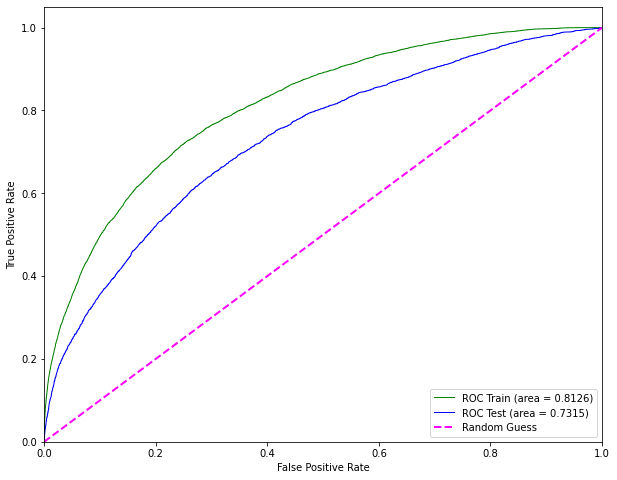

In [25]:
plt.figure(figsize=(10,8))

plt.plot(fpr_train, tpr_train, 
         color = 'green', 
         label = 'ROC Train (area = {:.4f})'.format(roc_auc_train), 
         lw = 1)
plt.plot(fpr_test, tpr_test, 
         color = 'blue', 
         label = 'ROC Test (area = {:.4f})'.format(roc_auc_test), 
         lw = 1)
plt.plot([0, 1], [0, 1], 
         color = 'magenta', 
         label = 'Random Guess', 
         lw = 2, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")

plt.show()

In [57]:
# Calculo threshold

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


In [28]:
# Threshold a utilizar es train
threshold_train = Find_Optimal_Cutoff(y_train, preds_lgbm_train)

threshold_test = Find_Optimal_Cutoff(y_test, preds_lgbm_test)

print("Threshold Train :", threshold_train)
print("Threshold Test :", threshold_test)

Threshold Train : [0.19202273617308685]
Threshold Test : [0.17805634688468952]


In [29]:
predicted = []
for x in preds_lgbm_test:
    if x >= threshold_train[0]:
        predicted.append(1)
    else:
        predicted.append(0)

# actual values
actual = list(y_test)
# predicted values
predicted

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Matriz de confusion : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual,predicted,labels=[0,1]).reshape(-1)
print('Valores : \n','TN: ',tn, '\n','FN: ',fn,'\n','FP: ',fp,'\n', 'TP: ',tp)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix)

Matriz de confusion : 
 [[11757  4855]
 [ 1393  2445]]
Valores : 
 TN:  11757 
 FN:  1393 
 FP:  4855 
 TP:  2445
Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79     16612
           1       0.33      0.64      0.44      3838

    accuracy                           0.69     20450
   macro avg       0.61      0.67      0.61     20450
weighted avg       0.79      0.69      0.72     20450



#### XGBoost

In [52]:
model_xgboost.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [41]:
#Tratamos de optimizar estos hiperparámetros:
def default_objective(trial):

    param = {
                "random_state"     : 42,  
                "num_leaves"       : trial.suggest_int("num_leaves", 2, 12),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 12),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "n_estimators"     : trial.suggest_int("n_estimators", 100, 600), 
                "learning_rate"   : trial.suggest_float('learning_rate', 0.01, 0.3),
                "reg_alpha": trial.suggest_loguniform('reg_alpha', 1e-1, 1e1),
                "reg_lambda": trial.suggest_loguniform('reg_lambda', 1e-1, 1e1),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
                ##"subsample"        : 1
            }

    
    
    model_pipeline = XGBClassifier(**param, silent=True,
                                            ##monotone_constraints=monotone_constraints,
                                            n_jobs=6)


    m = model_pipeline.fit(X_train, y_train)
    
    preds           = m.predict_proba(X_test)[:, 1]
    roc_score       = roc_auc_score(y_test, preds)
    preds_train     = m.predict_proba(X_train)[:, 1]
    roc_score_train = roc_auc_score(y_train, preds_train)
    trial.set_user_attr('overfit', roc_score_train - roc_score)
    if roc_score_train - roc_score < 0.045:
        return roc_score
    raise TrialPruned()

    if objective  == None:
        objective = default_objective
    else:
        objective = objective
    gc.collect()

In [42]:
def do_optuna_tuning(minimize_overfit = True):
    
    study = optuna.create_study(direction = "maximize")
    study.optimize(default_objective, n_trials = 100, n_jobs=6)

    if minimize_overfit:
        trial      = study.best_trial
        best_trial = sorted([t for t in study.trials if t.value != None and t.value >= trial.value - 0.0005],
                            key = lambda a: a.user_attrs['overfit'])[0]
    else:
        best_trial = study.best_trial
    params         = best_trial.params
    params.update({'random_state': 42}) 
    return study,trial,best_trial

In [43]:
gc.collect()
study,trial,best_trial=do_optuna_tuning()

[I 2023-02-15 15:17:15,967] A new study created in memory with name: no-name-5f37c595-3c14-4e53-9fcb-39f89411b14d
[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_sa

In [44]:
selected_trial = best_trial
selected_trial

FrozenTrial(number=42, state=TrialState.COMPLETE, values=[0.7263960286874875], datetime_start=datetime.datetime(2023, 2, 15, 15, 21, 46, 277616), datetime_complete=datetime.datetime(2023, 2, 15, 15, 22, 1, 890901), params={'num_leaves': 10, 'min_samples_split': 5, 'max_depth': 4, 'n_estimators': 212, 'learning_rate': 0.20301523697242135, 'reg_alpha': 0.6621121737222712, 'reg_lambda': 0.45890547125306674, 'feature_fraction': 0.9, 'random_state': 42}, user_attrs={'overfit': 0.044194259872910036}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=12, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=12, log=False, low=2, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=600, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': Floa

In [45]:
selected_params = {k:v for (k,v) in best_trial.params.items()}
selected_params

{'num_leaves': 10,
 'min_samples_split': 5,
 'max_depth': 4,
 'n_estimators': 212,
 'learning_rate': 0.20301523697242135,
 'reg_alpha': 0.6621121737222712,
 'reg_lambda': 0.45890547125306674,
 'feature_fraction': 0.9,
 'random_state': 42}

In [47]:
%%time 
# Corrida ganadora - Entrenamos el modelo con el dataframe de Train y los parámetros ganadores:
gc.collect()
params =  {'num_leaves': [10],
             'min_samples_split': [5],
             'max_depth': [4],
             'n_estimators': [212],
             'learning_rate': [0.20301523697242135],
             'reg_alpha': [0.6621121737222712],
             'reg_lambda': [0.8171377954100283],
             'feature_fraction': [0.45890547125306674],
             'random_state': [42]}

grid_search = GridSearchCV(estimator=model_xgboost, param_grid=params, 
                           cv=3, scoring='roc_auc', n_jobs=5)

grid_search.fit(X_train,y_train)

[15:28:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves" } are not used.

CPU times: user 14.8 s, sys: 1.25 s, total: 16.1 s
Wall time: 6.59 s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=5,
             param_

In [48]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([3.58357604]), 'std_fit_time': array([0.01381328]), 'mean_score_time': array([0.0434312]), 'std_score_time': array([0.00049669]), 'param_feature_fraction': masked_array(data=[0.45890547125306674],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.20301523697242135],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[4],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[212],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_random_state': masked_array(data=[42],
         

In [49]:
xgb_model = XGBClassifier(**selected_params, 
                            silent=True, metric = 'auc')
xgb_model.fit(X_train, y_train)

[15:28:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "metric", "min_samples_split", "num_leaves", "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_fraction=0.9,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.20301523697242135, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None, metric='auc',
              min_child_weight=None, min_samples_split=5, missing=nan,
              monotone_constraints=None, n_estimators=212, n_jobs=None, ...)

In [53]:
%%time

preds_xgb_train = xgb_model.predict_proba(X_train)[:,1]
preds_xgb_test = xgb_model.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_xgb_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_xgb_test) ,4)

print("ROC XGBoost Opt Train: " + str(train_roc))
print("ROC XGBoost Opt Test: " + str(test_roc))

ROC XGBoost Opt Train: 0.7706
ROC XGBoost Opt Test: 0.7264
CPU times: user 479 ms, sys: 46.4 ms, total: 525 ms
Wall time: 91.4 ms


In [54]:
#Visualización de métricas de performance:
#Train Modelo Nuevo
fpr_train, tpr_train, _ = roc_curve(y_train, preds_xgb_train)
roc_auc_train = auc(fpr_train, tpr_train)

#Test Modelo Nuevo
fpr_test, tpr_test, _ = roc_curve(y_test, preds_xgb_test)
roc_auc_test = auc(fpr_test, tpr_test)

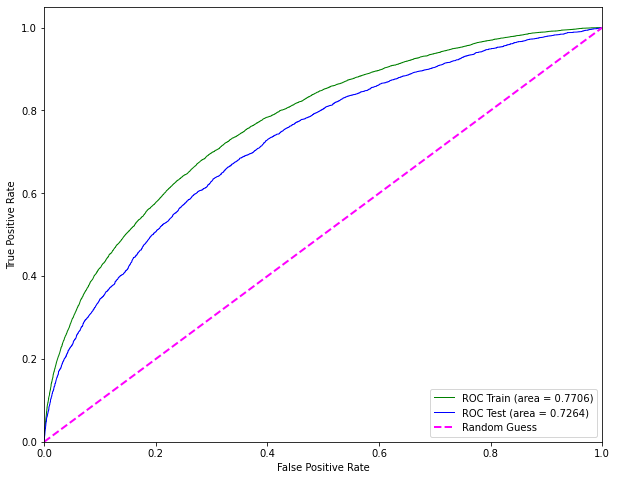

In [55]:
plt.figure(figsize=(10,8))

plt.plot(fpr_train, tpr_train, 
         color = 'green', 
         label = 'ROC Train (area = {:.4f})'.format(roc_auc_train), 
         lw = 1)
plt.plot(fpr_test, tpr_test, 
         color = 'blue', 
         label = 'ROC Test (area = {:.4f})'.format(roc_auc_test), 
         lw = 1)
plt.plot([0, 1], [0, 1], 
         color = 'magenta', 
         label = 'Random Guess', 
         lw = 2, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")

plt.show()

In [58]:
# Threshold a utilizar es train
threshold_train = Find_Optimal_Cutoff(y_train, preds_xgb_train)

threshold_test = Find_Optimal_Cutoff(y_test, preds_xgb_test)

print("Threshold Train :", threshold_train)
print("Threshold Test :", threshold_test)

Threshold Train : [0.18748228251934052]
Threshold Test : [0.182092547416687]


In [60]:
predicted = []
for x in preds_xgb_test:
    if x >= threshold_train[0]:
        predicted.append(1)
    else:
        predicted.append(0)

# actual values
actual = list(y_test)
# predicted values
predicted

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Matriz de confusion : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual,predicted,labels=[0,1]).reshape(-1)
print('Valores : \n','TN: ',tn, '\n','FN: ',fn,'\n','FP: ',fp,'\n', 'TP: ',tp)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix)

Matriz de confusion : 
 [[11341  5271]
 [ 1353  2485]]
Valores : 
 TN:  11341 
 FN:  1353 
 FP:  5271 
 TP:  2485
Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.68      0.77     16612
           1       0.32      0.65      0.43      3838

    accuracy                           0.68     20450
   macro avg       0.61      0.67      0.60     20450
weighted avg       0.79      0.68      0.71     20450



In [62]:
feat_imp_xgb = pd.DataFrame()
feat_imp_xgb['Variable'] = X_train.columns
feat_imp_xgb['importance'] = xgb_model.feature_importances_
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)
feat_imp_xgb

,Variable,importance
4,tipo_vuelo,0.330058
5,periodo_dia,0.087492
1,mes,0.078245
14,cod_aerolinea,0.069174
13,cod_destino,0.064680
8,Lunes,0.055931
2,temporada_alta,0.048162
12,Viernes,0.047001
7,Jueves,0.041353
0,dia,0.040863


Si comparamos los modelos:

LGBM Original:
ROC LGBM Baseline Train: 0.7737
ROC LGBM Baseline Test: 0.7286

LGBM Optimizado:
ROC LGBM Opt Train: 0.8126
ROC LGBM Opt Test: 0.7315

XGB Original:
ROC XGBoost Baseline Train: 0.8273
ROC XGBoost Baseline Test: 0.7321


XGB Optimizado:
ROC XGBoost Opt Train: 0.7706
ROC XGBoost Opt Test: 0.7264

Vemos que todos performan de manera muy similar. 

Un dato importante que podríamos destacar es que a medida en que optimizamos XGBoost, perdemos poder predictivo en test pero lo positivo es que la brecha entre train y test se achica, lo que implicaría que nuestro modelo overfittea menos. 

Por otro lado, si vemos LGBM, al optimizarlo la brecha entre train y test crece, pero tambien suben los rendimientos. 

Sin embargo, todos los resultados son muy similares y así mismo, al ser modelos de por si muy optimizados, la optimización extra no aporta poder predictivo ni cambios significativos en nuestros modelos.


Para mejorar performance, podríamos incluir nuevas variables, por ejemplo cantidad de empleados de la aerolínea (si la aerolinea tiene poco personal, hay mas posibilidades de que se atrase el vuelo por falta de tripulacion), información sobre los feriados calendario, personal del aeropuerto, etc.
Otra opción que creemos interesante probar, es sumar otro año más al dataset (ejemplo 2018), ya que como no son tantos registros, no nos llevaría tanto tiempo de procesamiento.

Notamos que el tipo de vuelo, periodo del día (tarde, noche o mañana) y el mes del año, son variables muy importantes al momento de predecir.

Sería bueno poder validar estos resultados con una base OOT (out of time), la cual no quisimos seleccionar de nuestra base inicial, debido a que queríamos realizar el entrenamiento con el año completo para que el modelo pueda captar la estacionalidad.
